In [1]:
!rm -rf /kaggle/working/DINO
!git clone https://github.com/aditdesai/DINO.git

Cloning into 'DINO'...
remote: Enumerating objects: 733, done.
remote: Counting objects: 100% (481/481), done.
remote: Compressing objects: 100% (346/346), done.
remote: Total 733 (delta 189), reused 367 (delta 129), pack-reused 252 (from 1)
Receiving objects: 100% (733/733), 38.38 MiB | 20.58 MiB/s, done.
Resolving deltas: 100% (245/245), done.


In [2]:
!conda install -c pytorch pytorch torchvision -y
%cd DINO
!pip install -r requirements.txt
%cd models/dino/ops
!python setup.py build install
!python test.py
%cd ../../..

Channels:
 - pytorch
 - rapidsai
 - nvidia
 - nodefaults
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.

/kaggle/working/DINO
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-install-m34akiey/pycocotools_591ab7527ecd45e1aae6c546beb66526
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-install-m34akiey/pycocotools_591ab7527ecd45e1aae6c546beb66526
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-install-m34akiey/panopticapi_683745f9a53f44cdb5059d19756cb3bd
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-install-m34akiey/panopticapi_683745f9a53f44cdb5059d19756cb3bd
  Resolved https://github.com/cocodataset/panopticapi.git 

In [3]:
!pip install numpy==1.23.5 yapf==0.40.1

In [4]:
!bash /kaggle/working/DINO/scripts/DINO_train.sh /kaggle/input/ped-ds/dataset --pretrain_model_path /kaggle/input/dino-model/checkpoint0033_4scale.pth --finetune_ignore label_enc.weight class_embed

Not using distributed mode
Loading config file from config/DINO/DINO_4scale_ft.py
[09/24 06:09:33.342]: git:
  sha: 5f921e7b36ba892ee3382731eba43fe42d3f4b2e, status: clean, branch: main

[09/24 06:09:33.342]: Command: main.py --output_dir logs/DINO/R50-MS4 -c config/DINO/DINO_4scale_ft.py --coco_path /kaggle/input/ped-ds/dataset --options dn_scalar=100 embed_init_tgt=TRUE dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False dn_box_noise_scale=1.0
[09/24 06:09:33.342]: Full config saved to logs/DINO/R50-MS4/config_args_all.json
[09/24 06:09:33.342]: world size: 1
[09/24 06:09:33.342]: rank: 0
[09/24 06:09:33.343]: local_rank: 0
[09/24 06:09:33.343]: args: Namespace(config_file='config/DINO/DINO_4scale_ft.py', options={'dn_scalar': 100, 'embed_init_tgt': True, 'dn_label_coef': 1.0, 'dn_bbox_coef': 1.0, 'use_ema': False, 'dn_box_noise_scale': 1.0}, dataset_file='coco', coco_path='/kaggle/input/ped-ds/dataset', coco_panoptic_path=None, remove_difficult=False, fix_size=False, output_dir='logs/D

In [5]:
!ls /kaggle/working/DINO/

LICENSE      figs				run_with_submitit.py
README.md    inference_and_visualization.ipynb	scripts
__pycache__  logs				tools
config	     main.py				util
datasets     models
engine.py    requirements.txt


In [51]:
!bash /kaggle/working/DINO/scripts/DINO_eval_ft.sh /kaggle/input/ped-ds/dataset /kaggle/working/DINO/logs/DINO/R50-MS4/checkpoint_best_regular.pth

Not using distributed mode
Loading config file from config/DINO/DINO_4scale_ft.py
[09/24 07:20:02.914]: git:
  sha: 5f921e7b36ba892ee3382731eba43fe42d3f4b2e, status: clean, branch: main

[09/24 07:20:02.915]: Command: main.py --output_dir logs/DINO/R50-MS4-%j -c config/DINO/DINO_4scale_ft.py --coco_path /kaggle/input/ped-ds/dataset --eval --resume /kaggle/working/DINO/logs/DINO/R50-MS4/checkpoint_best_regular.pth --options dn_scalar=100 embed_init_tgt=TRUE dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False dn_box_noise_scale=1.0
[09/24 07:20:02.915]: Full config saved to logs/DINO/R50-MS4-%j/config_args_all.json
[09/24 07:20:02.915]: world size: 1
[09/24 07:20:02.915]: rank: 0
[09/24 07:20:02.916]: local_rank: 0
[09/24 07:20:02.916]: args: Namespace(config_file='config/DINO/DINO_4scale_ft.py', options={'dn_scalar': 100, 'embed_init_tgt': True, 'dn_label_coef': 1.0, 'dn_bbox_coef': 1.0, 'use_ema': False, 'dn_box_noise_scale': 1.0}, dataset_file='coco', coco_path='/kaggle/input/ped-ds/data

In [7]:
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

In [45]:
model_config_path = "/kaggle/working/DINO/config/DINO/DINO_4scale_ft.py"
model_checkpoint_path = "/kaggle/working/DINO/logs/DINO/R50-MS4/checkpoint_best_regular.pth"

In [46]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

/tmp/ipykernel_787/2480974019.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_checkpoint_path, map_location='cpu')


In [47]:
# load coco names
with open('/kaggle/working/DINO/util/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

In [61]:
from PIL import Image
import datasets.transforms as T

image = Image.open("/kaggle/input/pedestrians/dataset/val2017/5879.jpg").convert("RGB") # load image

# transform images
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

In [62]:
# predict images
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

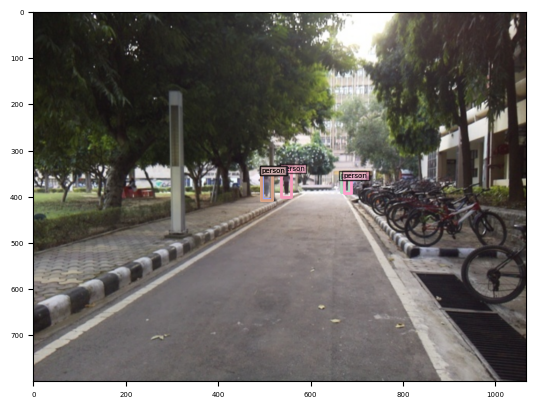

In [63]:
# visualize outputs
thershold = 0.3 # set a thershold

vslzr = COCOVisualizer()

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None, dpi=100)